### Topic: Latent Semantic Analysis

Team members: 
*   Yash Khandelwal (PID: A00000000)



In [1]:
# importspip in
import numpy as np
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=4)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

### Load dataset and print basic stats

In [2]:
#Load dataset
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
dataset = fetch_20newsgroups(subset='train', remove=remove, shuffle = True)
dataset.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [3]:
# len of training and testing dataset
print("Length of data:", len(dataset.data))

Length of data: 11314


In [4]:
# get the list of 20 labels
pp.pprint(dataset.target_names)

[   'alt.atheism',
    'comp.graphics',
    'comp.os.ms-windows.misc',
    'comp.sys.ibm.pc.hardware',
    'comp.sys.mac.hardware',
    'comp.windows.x',
    'misc.forsale',
    'rec.autos',
    'rec.motorcycles',
    'rec.sport.baseball',
    'rec.sport.hockey',
    'sci.crypt',
    'sci.electronics',
    'sci.med',
    'sci.space',
    'soc.religion.christian',
    'talk.politics.guns',
    'talk.politics.mideast',
    'talk.politics.misc',
    'talk.religion.misc']


### Exploratory Data Analysis

In [5]:
# put it into dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})

# get dimensions of data 
news_df.shape

(11314, 2)

In [6]:
news_df.head()

,News,Target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [7]:
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])

In [8]:
news_df.head()

,News,Target,Target_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


Text(0.5, 0, 'Count of topics')

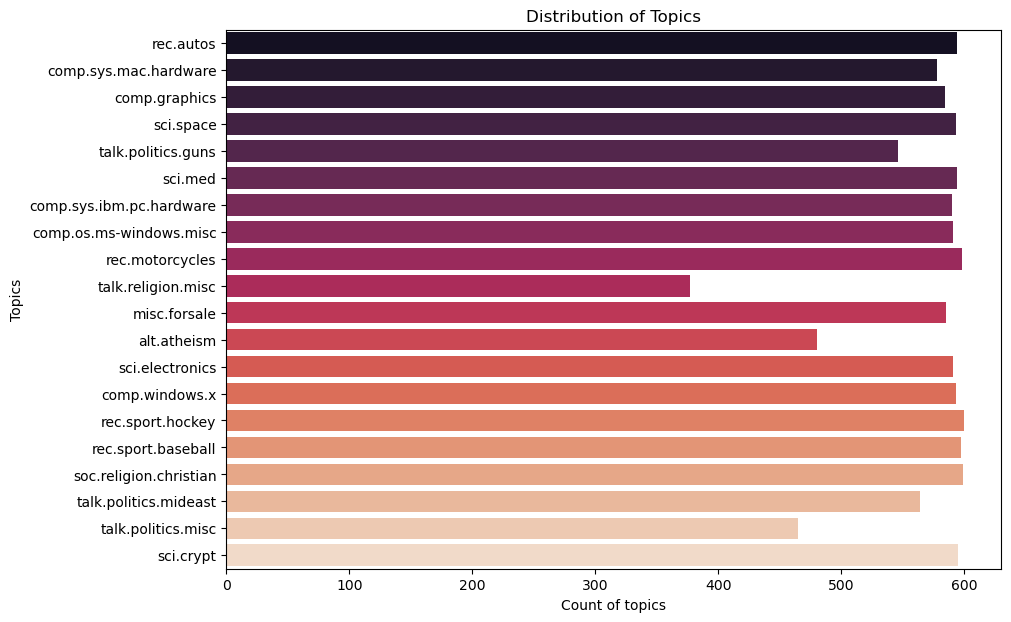

In [9]:
# plot distribution of topics in news data
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_df['Target_name'], palette='rocket')
plt.title('Distribution of Topics')
plt.ylabel('Topics')
plt.xlabel('Count of topics')

### Text Preprocessing

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mkilaru/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mkilaru/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/mkilaru/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mkilaru/nltk_data...


True

In [11]:
# tokenize
# remove non alphabetic characters
# remove stopwords and lemmatize

In [12]:
import regex as re
def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # remove very small words, length < 3 as they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
    
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence


In [13]:
tqdm.pandas()
# clean text data
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

  0%|          | 0/11314 [00:00<?, ?it/s]

In [14]:
news_df.head()

,News,Target,Target_name
0,wondering anyone could enlighten car saw day d...,7,rec.autos
1,fair number brave soul upgraded clock oscillat...,4,comp.sys.mac.hardware
2,well folk mac plus finally gave ghost weekend ...,4,comp.sys.mac.hardware
3,weitek address phone number like get informati...,1,comp.graphics
4,article owcb world std com tombaker world std ...,14,sci.space


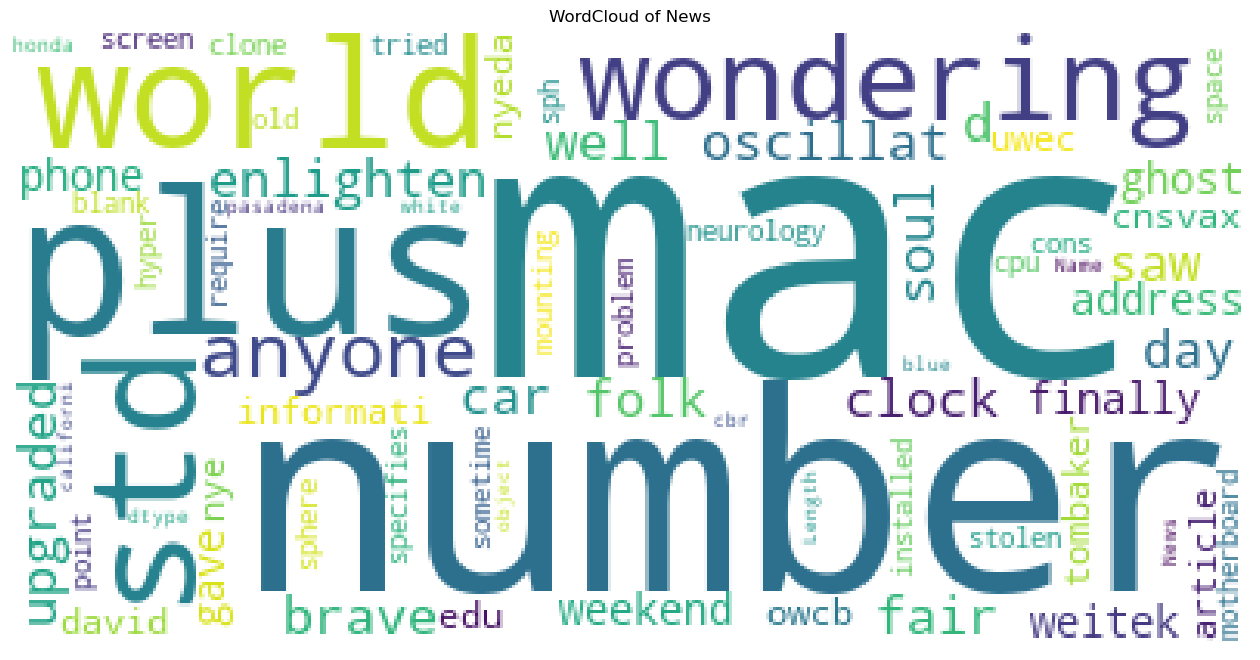

In [15]:
# plot word count for news text
wordcloud = WordCloud(background_color='white',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [16]:
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split(), max_df=0.95, min_df=2)
X = tfid_vec.fit_transform(news_df['News'])
X.shape

(11314, 29947)

### Latent Semantic Analysis

In [17]:
# create svd instance
svd_model = TruncatedSVD(n_components=20,
                         algorithm='randomized')

# fit model to data
svd_model.fit(X)

TruncatedSVD(n_components=20)

In [18]:
# topic word mapping martrix
svd_model.components_.shape

(20, 29947)

In [19]:
# document topic mapping matrix
doc_topic = svd_model.fit_transform(X)
doc_topic.shape

(11314, 20)

In [20]:
terms = tfid_vec.get_feature_names_out()

In [21]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:5].index)
        
    return word2topics

In [22]:
word2topics = map_word2topic(svd_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics.index, word2topics):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['would', 'one', 'know', 'like', 'get']
topic 1 	 ['window', 'drive', 'card', 'file', 'thanks']
topic 2 	 ['drive', 'game', 'team', 'year', 'scsi']
topic 3 	 ['key', 'chip', 'encryption', 'clipper', 'government']
topic 4 	 ['key', 'drive', 'chip', 'scsi', 'god']
topic 5 	 ['edu', 'geb', 'thanks', 'cadre', 'dsl']
topic 6 	 ['window', 'geb', 'pitt', 'dsl', 'chastity']
topic 7 	 ['game', 'god', 'key', 'team', 'chip']
topic 8 	 ['card', 'driver', 'video', 'monitor', 'color']
topic 9 	 ['armenian', 'card', 'israel', 'game', 'israeli']
topic 10 	 ['sale', 'edu', 'offer', 'space', 'new']
topic 11 	 ['window', 'armenian', 'car', 'key', 'please']
topic 12 	 ['file', 'car', 'armenian', 'driver', 'key']
topic 13 	 ['armenian', 'turkish', 'anyone', 'problem', 'bit']
topic 14 	 ['israel', 'would', 'israeli', 'arab', 'jew']
topic 15 	 ['israel', 'israeli', 'arab', 'com', 'problem']
topic 16 	 ['one', 'monitor', 'gun', 'get', 'thanks']
topic 17 	 ['com', 'would', 'port', 'mode

In [23]:
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # list of topics
    topics = ['topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

In [24]:
top_topics = map_topicword2doc(svd_model, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

  0%|          | 0/11314 [00:00<?, ?it/s]

In [25]:
# convert probability from string to float
news_topics = news_topics.infer_objects()

In [26]:
news_topics.head(2)

,News,Target,Target_name,topic_1_name,topic_2_name,topic_3_name,topic_1_prob,topic_2_prob,topic_3_prob
0,wondering anyone could enlighten car saw day d...,7,rec.autos,topic12,topic0,topic11,0.191770,0.154767,0.151804
1,fair number brave soul upgraded clock oscillat...,4,comp.sys.mac.hardware,topic0,topic1,topic2,0.106776,0.088638,0.050394


Text(0.5, 0, 'Count of topic 1')

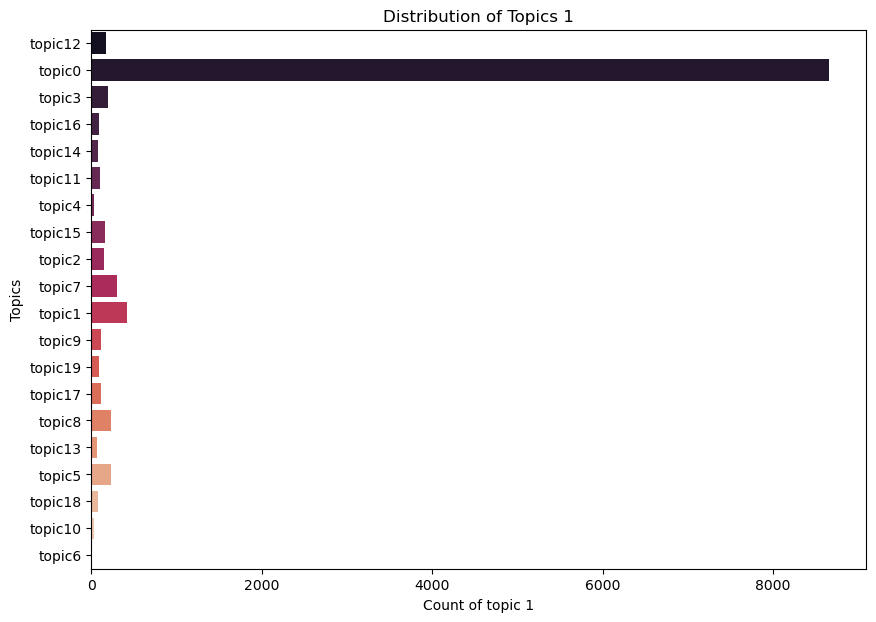

In [27]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_1_name'], palette='rocket')
plt.title('Distribution of Topics 1')
plt.ylabel('Topics')
plt.xlabel('Count of topic 1')

Text(0.5, 0, 'Count of topic 2')

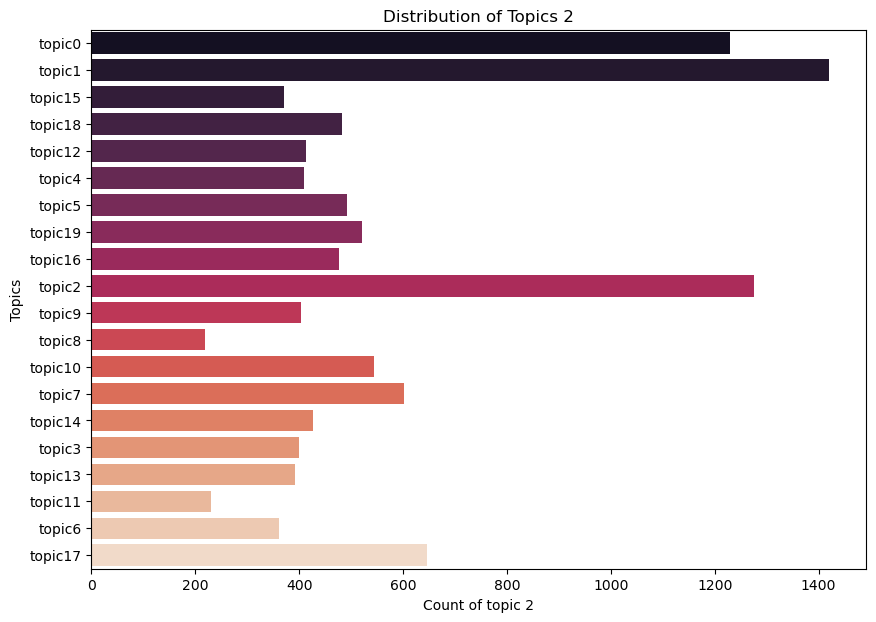

In [28]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_2_name'], palette='rocket')
plt.title('Distribution of Topics 2')
plt.ylabel('Topics')
plt.xlabel('Count of topic 2')

Text(0.5, 0, 'Count of topic 3')

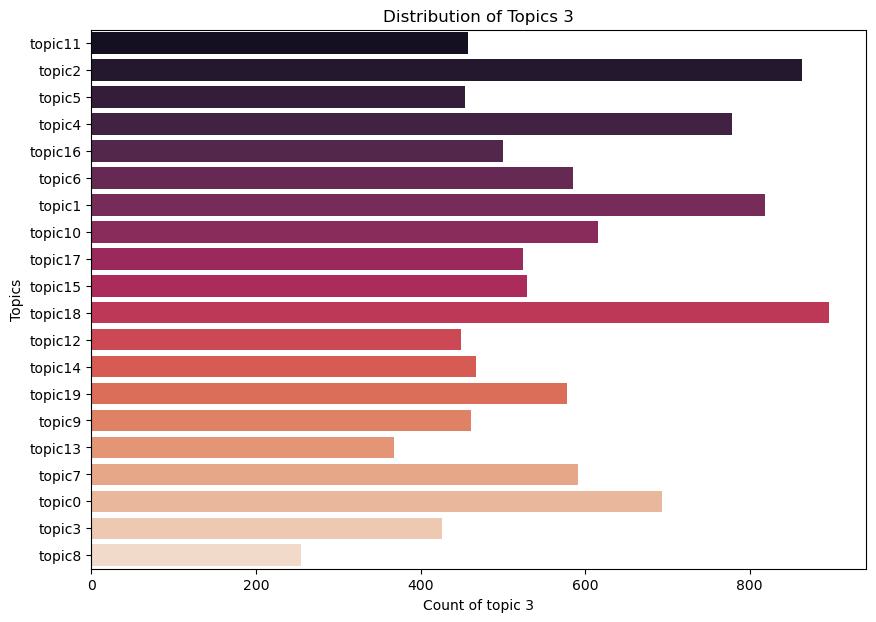

In [29]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_3_name'], palette='rocket')
plt.title('Distribution of Topics 3')
plt.ylabel('Topics')
plt.xlabel('Count of topic 3')

In [30]:
X_topics = svd_model.fit_transform(X) 

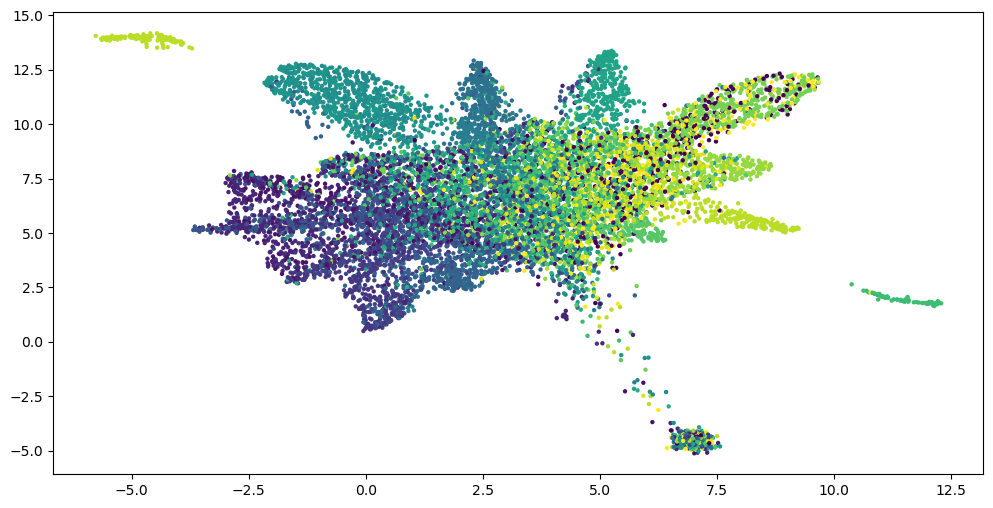

In [33]:
import umap 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 
plt.figure(figsize=(12,6)) 
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target, 
s = 10, # size 
edgecolor='none' ) 
plt.show()

### Latent Dirichlet Allocation (LDA)

In [34]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=20,
                                     max_iter=20)

In [35]:
lda_model.fit(X)

LatentDirichletAllocation(max_iter=20, n_components=20)

In [36]:
doc_topic_lda = lda_model.transform(X)

In [37]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['fpu', 'chi', 'illinois', 'cal', 'revolver']
topic 1 	 ['retarded', 'hci', 'rockies', 'dxf', 'egalon']
topic 2 	 ['patent', 'nist', 'azeri', 'henrik', 'ulf']
topic 3 	 ['eisa', 'dma', 'lciii', 'sec', 'ditto']
topic 4 	 ['alomar', 'shaft', 'mormon', 'feustel', 'baerga']
topic 5 	 ['armenian', 'turkish', 'max', 'turk', 'armenia']
topic 6 	 ['detector', 'radar', 'compaq', 'radiosity', 'cruel']
topic 7 	 ['would', 'one', 'people', 'think', 'like']
topic 8 	 ['borland', 'cbr', 'beyer', 'handlebar', 'ski']
topic 9 	 ['champ', 'mom', 'ink', 'sa', 'keller']
topic 10 	 ['pitt', 'gordon', 'geb', 'cadre', 'surrender']
topic 11 	 ['captain', 'traded', 'easter', 'canadiens', 'mumble']
topic 12 	 ['tek', 'risc', 'bronx', 'manhattan', 'ico']
topic 13 	 ['catbyte', 'dtmedin', 'ingr', 'sarcasm', 'huntsville']
topic 14 	 ['window', 'thanks', 'file', 'drive', 'card']
topic 15 	 ['calgary', 'period', 'winnipeg', 'azerbaijani', 'eric']
topic 16 	 ['cview', 'perry', 'pocket', 'shear

In [38]:
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # list of topics
    topics = ['topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

In [39]:
top_topics = map_topicword2doc(lda_model, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

  0%|          | 0/11314 [00:00<?, ?it/s]

Text(0.5, 0, 'Count of topics')

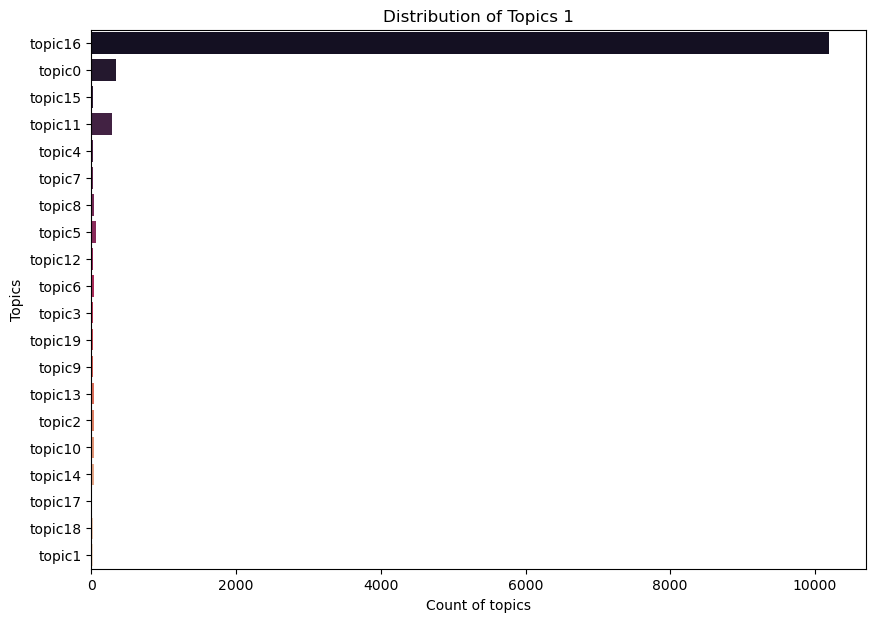

In [40]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_1_name'], palette='rocket')
plt.title('Distribution of Topics 1')
plt.ylabel('Topics')
plt.xlabel('Count of topics')

Text(0.5, 0, 'Count of topics')

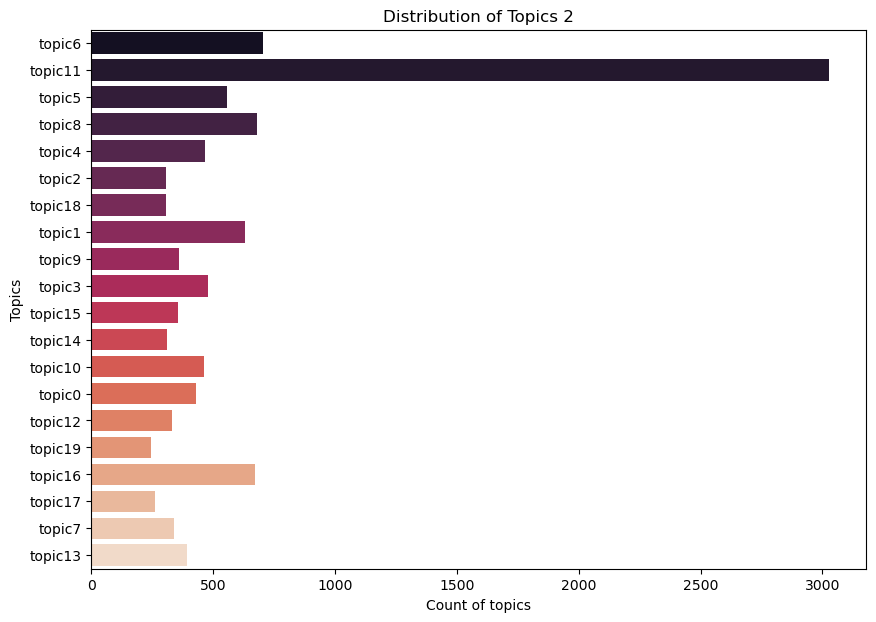

In [41]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_2_name'], palette='rocket')
plt.title('Distribution of Topics 2')
plt.ylabel('Topics')
plt.xlabel('Count of topics')

Text(0.5, 0, 'Count of topics')

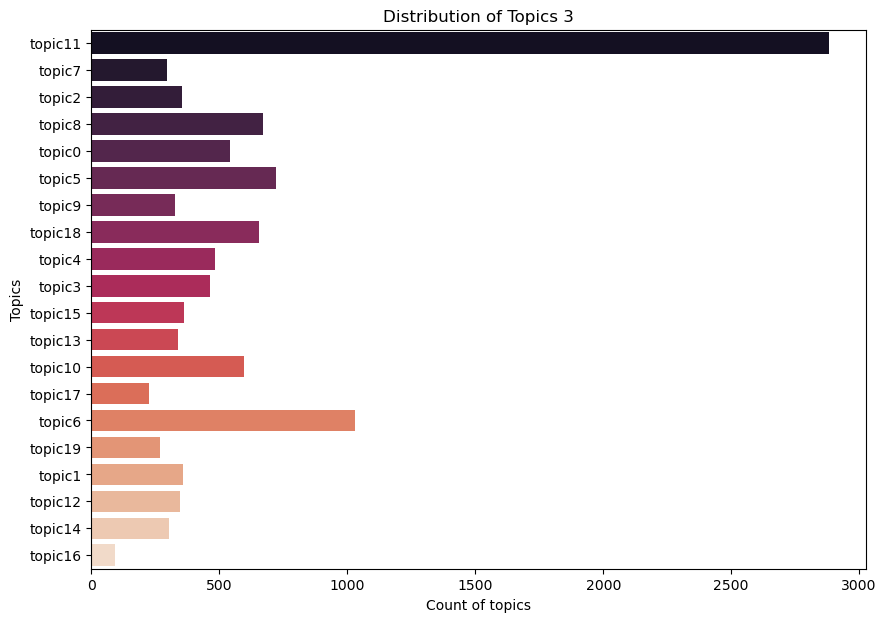

In [42]:
fig = plt.figure(figsize=[10,7])
ax = sns.countplot(y=news_topics['topic_3_name'], palette='rocket')
plt.title('Distribution of Topics 3')
plt.ylabel('Topics')
plt.xlabel('Count of topics')

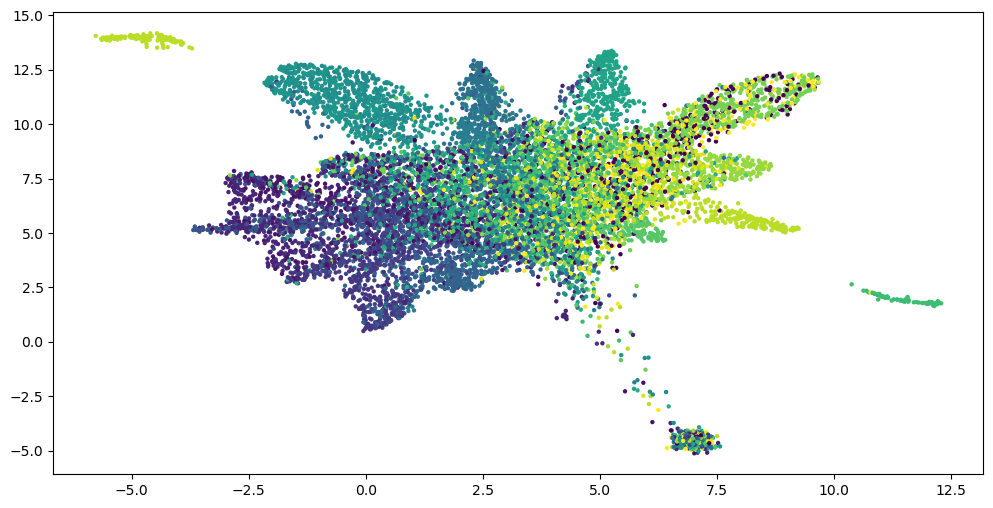

In [43]:
import umap 
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics) 
plt.figure(figsize=(12,6)) 
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target, 
s = 10, # size 
edgecolor='none' ) 
plt.show()